In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torchvision

from torch.utils.data import random_split, DataLoader, Dataset
from torchvision.transforms import transforms

from PIL import Image
from torchinfo import summary
from sklearn.metrics import ConfusionMatrixDisplay

In [2]:
train_features = pd.read_csv("data/train_features.csv", index_col="id")
test_features = pd.read_csv("data/test_features.csv", index_col="id")
train_labels = pd.read_csv("data/train_labels.csv", index_col="id")

In [3]:
train_labels.head()

antelope_duiker  bird  blank  civet_genet  hog  leopard  \
id                                                                  
ZJ000000              0.0   1.0    0.0          0.0  0.0      0.0   
ZJ000001              0.0   0.0    0.0          0.0  0.0      0.0   
ZJ000002              0.0   1.0    0.0          0.0  0.0      0.0   
ZJ000003              0.0   0.0    0.0          0.0  0.0      0.0   
ZJ000004              0.0   0.0    0.0          0.0  0.0      1.0   

          monkey_prosimian  rodent  
id                                  
ZJ000000               0.0     0.0  
ZJ000001               1.0     0.0  
ZJ000002               0.0     0.0  
ZJ000003               1.0     0.0  
ZJ000004               0.0     0.0

In [4]:
train_features.head()

filepath   site
id                                          
ZJ000000  train_features/ZJ000000.jpg  S0120
ZJ000001  train_features/ZJ000001.jpg  S0069
ZJ000002  train_features/ZJ000002.jpg  S0009
ZJ000003  train_features/ZJ000003.jpg  S0008
ZJ000004  train_features/ZJ000004.jpg  S0036

In [5]:
test_features.head()

filepath   site
id                                         
ZJ016488  test_features/ZJ016488.jpg  S0082
ZJ016489  test_features/ZJ016489.jpg  S0040
ZJ016490  test_features/ZJ016490.jpg  S0040
ZJ016491  test_features/ZJ016491.jpg  S0041
ZJ016492  test_features/ZJ016492.jpg  S0040

In [6]:
species_labels = sorted(train_labels.columns.unique())
species_labels

['antelope_duiker',
 'bird',
 'blank',
 'civet_genet',
 'hog',
 'leopard',
 'monkey_prosimian',
 'rodent']

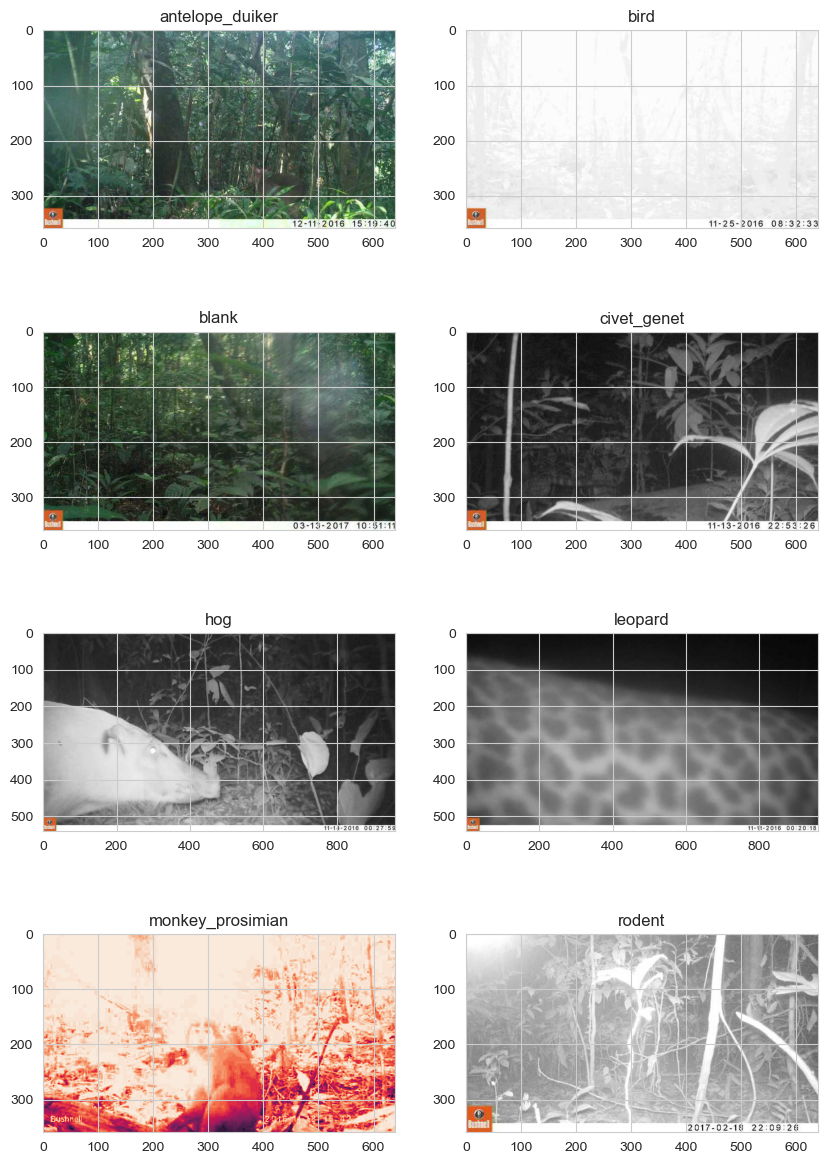

In [12]:
random_state = 23

fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(10, 15))

for species, ax in zip(species_labels, axes.flat):

    img_id = (
        train_labels[train_labels.loc[:,species] == 1]
        .sample(1, random_state=random_state)
        .index[0],
    )

    img = Image.open("data/" + train_features.loc[img_id].filepath)

    ax.imshow(img)
    ax.set_title(species)

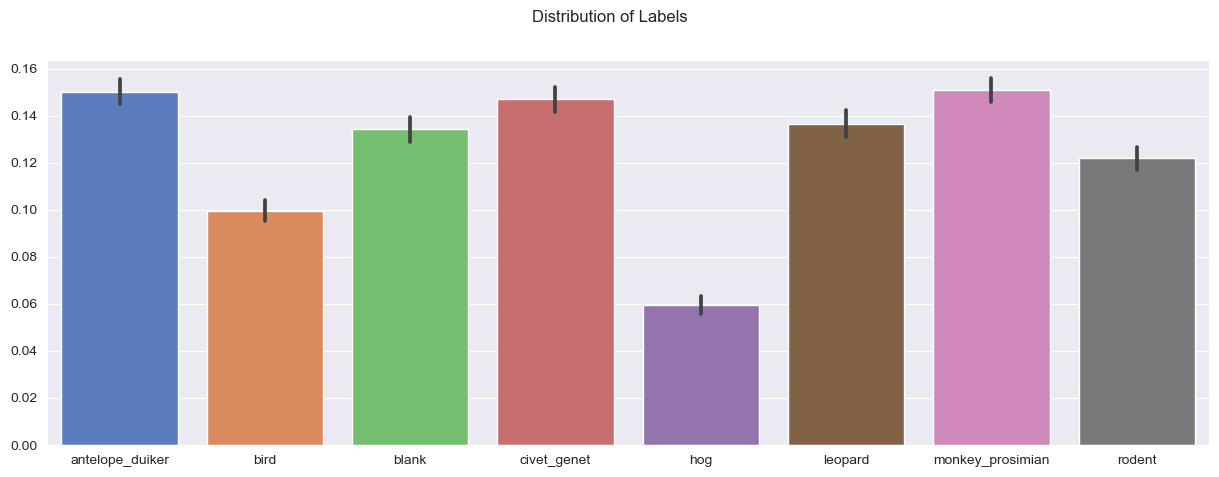

In [93]:
fig = plt.figure(figsize=(15, 5))
sns.set_palette("muted")
sns.barplot(data=train_labels)
fig.suptitle("Distribution of Labels")
plt.show()

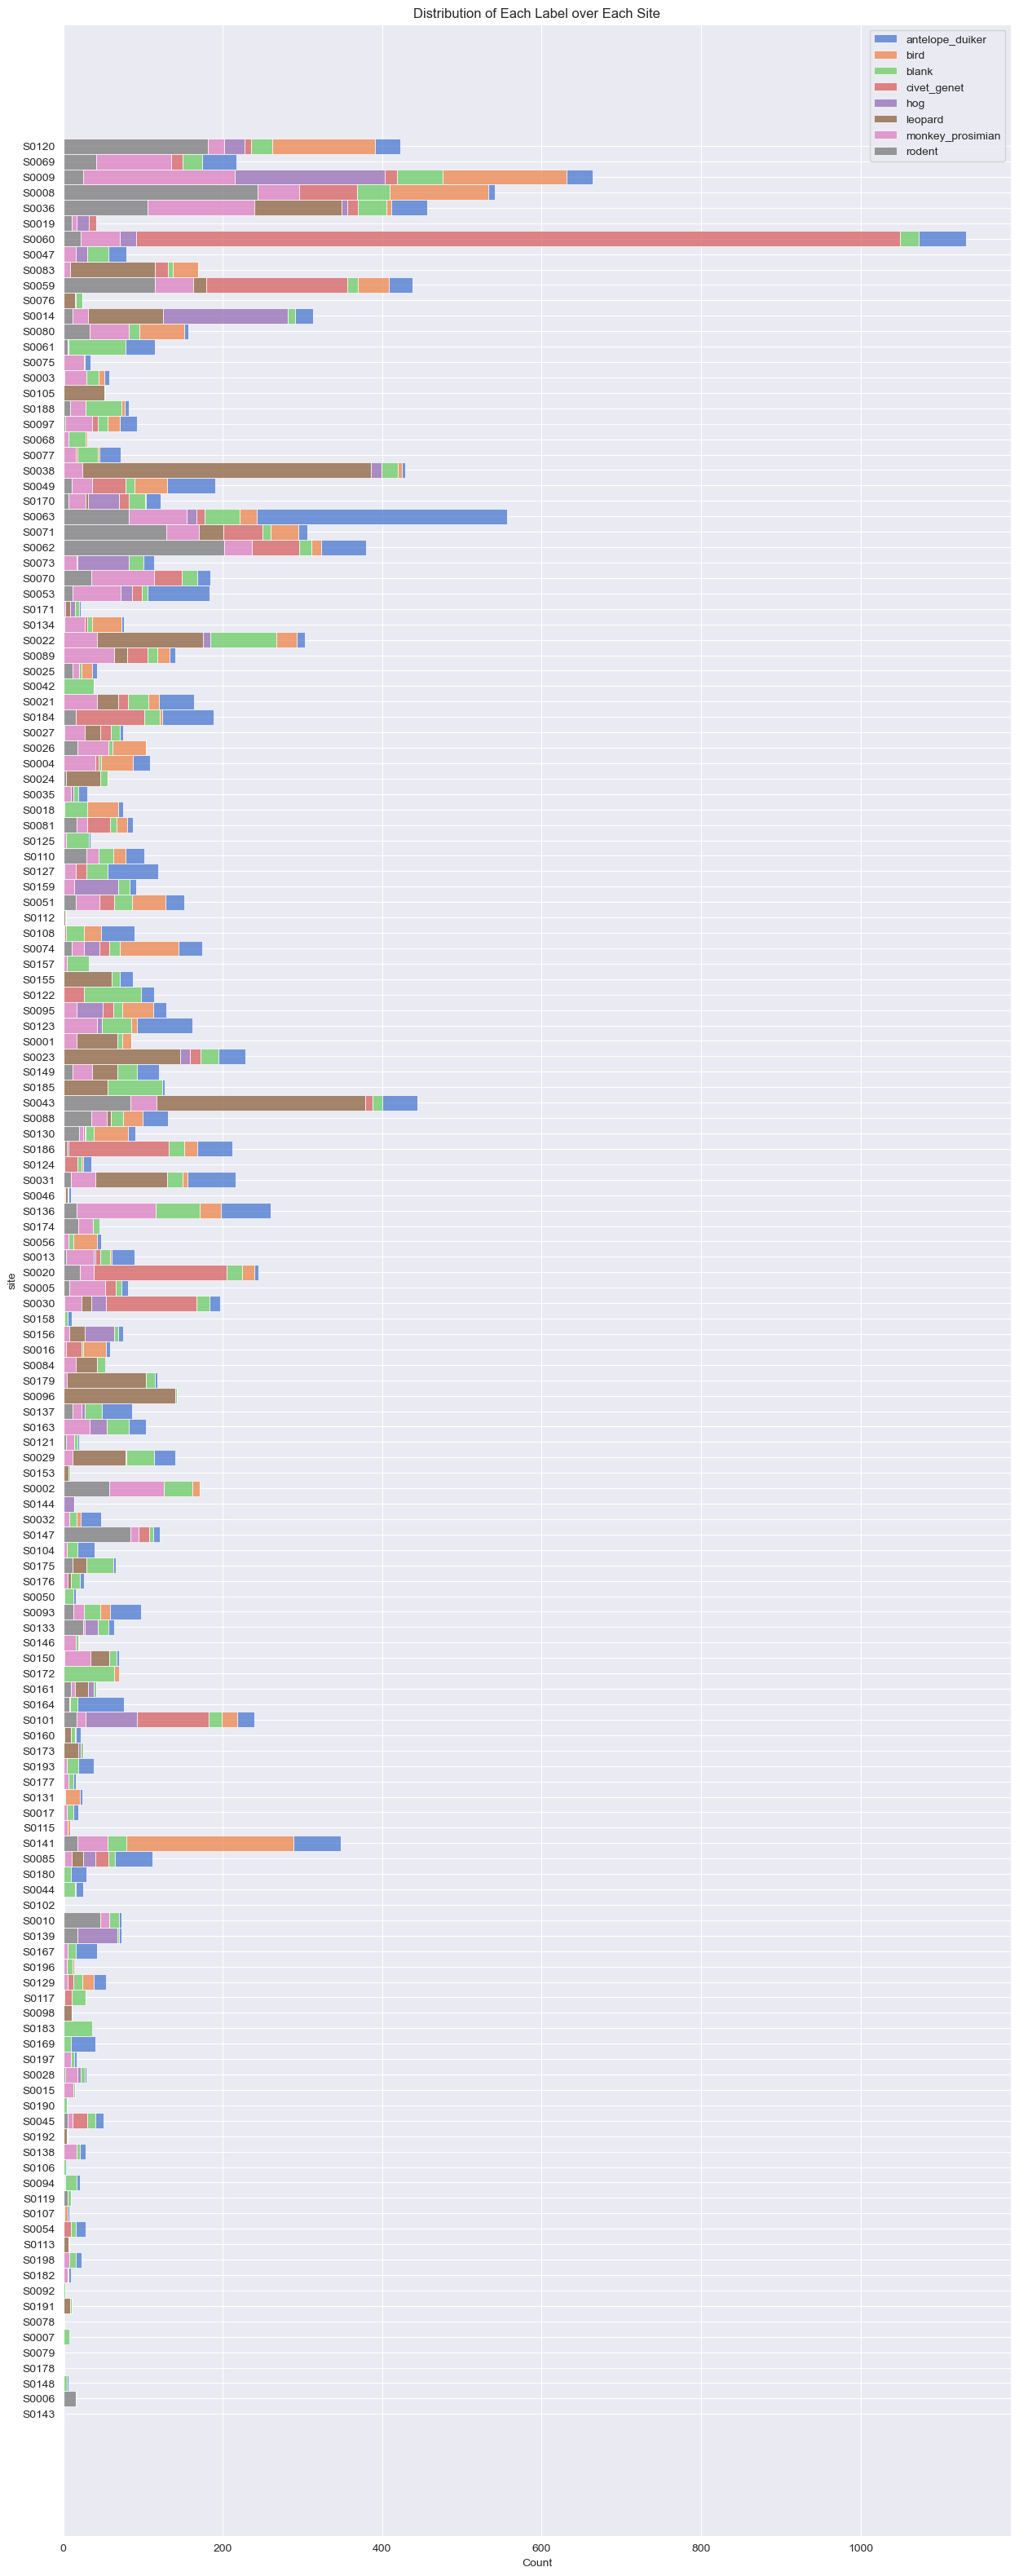

In [95]:
f, ax = plt.subplots(figsize=(15, 40))
sns.set_style("darkgrid")
sns.set_palette("muted")
sns.histplot(data = train_labels.join(train_features, on="id"),
            y="site", hue=train_labels.idxmax(axis=1), multiple="stack", linewidth=.5,
             hue_order=["antelope_duiker", "bird", "blank", "civet_genet", "hog", "leopard", "monkey_prosimian", "rodent"])
ax.set_title("Distribution of Each Label over Each Site")
plt.show()

In [3]:
class ConserVisionDataset(Dataset):

    def __init__(self, features_df, labels_df=None, transform=None):
        self.features_df = features_df
        self.labels_df = labels_df
        self.transform = transform

    def __getitem__(self, index):
        image = Image.open("data/" + self.features_df.iloc[index]["filepath"]).convert("RGB")
        if self.transform:
            image = self.transform(image)

        image_id = self.features_df.index[index]
        site = self.features_df["site"][index]

        if self.labels_df is not None:
            label = torch.tensor(self.labels_df.iloc[index].values, dtype=torch.float)
            sample = {"image_id": image_id, "image": image, "site": site,
                      "label": label, "top_label": self.labels_df.idxmax(axis=1)[index]}
        else:
            sample = {"image_id": image_id, "image": image, "site": site}
        return sample

    def __len__(self):
        return len(self.features_df)

In [4]:
train_dataset = ConserVisionDataset(train_features, labels_df=train_labels, transform=None)

In [5]:
augmentation = transforms.Compose(
                [
                    transforms.RandomHorizontalFlip(0.5),
                    transforms.RandomRotation(10),
                    transforms.ColorJitter(.7, .5, .5, (-0.15, 0.3)),
                    transforms.RandomAdjustSharpness(1.5, 0.2),
                    transforms.RandomAdjustSharpness(0.1, 0.2),
                    transforms.RandomApply(torch.nn.ModuleList([transforms.RandomGrayscale(1), transforms.RandomInvert(0.5)]), 0.2),
                ])

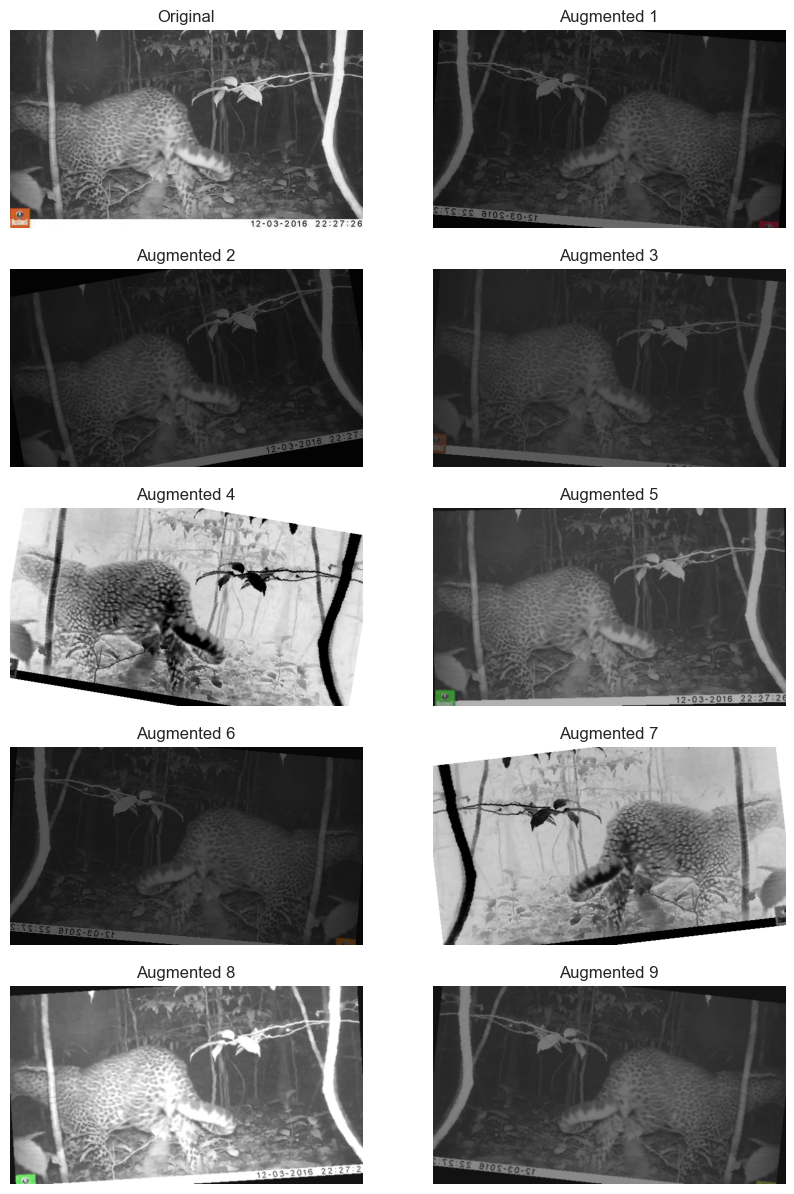

In [19]:
example = train_dataset[1983]
figure = plt.figure(figsize=(10, 15))

plt.subplot(5, 2, 1)
plt.axis("off")
plt.imshow(example["image"])
plt.title("Original")

for i in range(2, 11):
    plt.subplot(5, 2, i)
    plt.axis("off")
    plt.imshow(augmentation(example["image"]))
    plt.title(f"Augmented {i-1}")
plt.show()

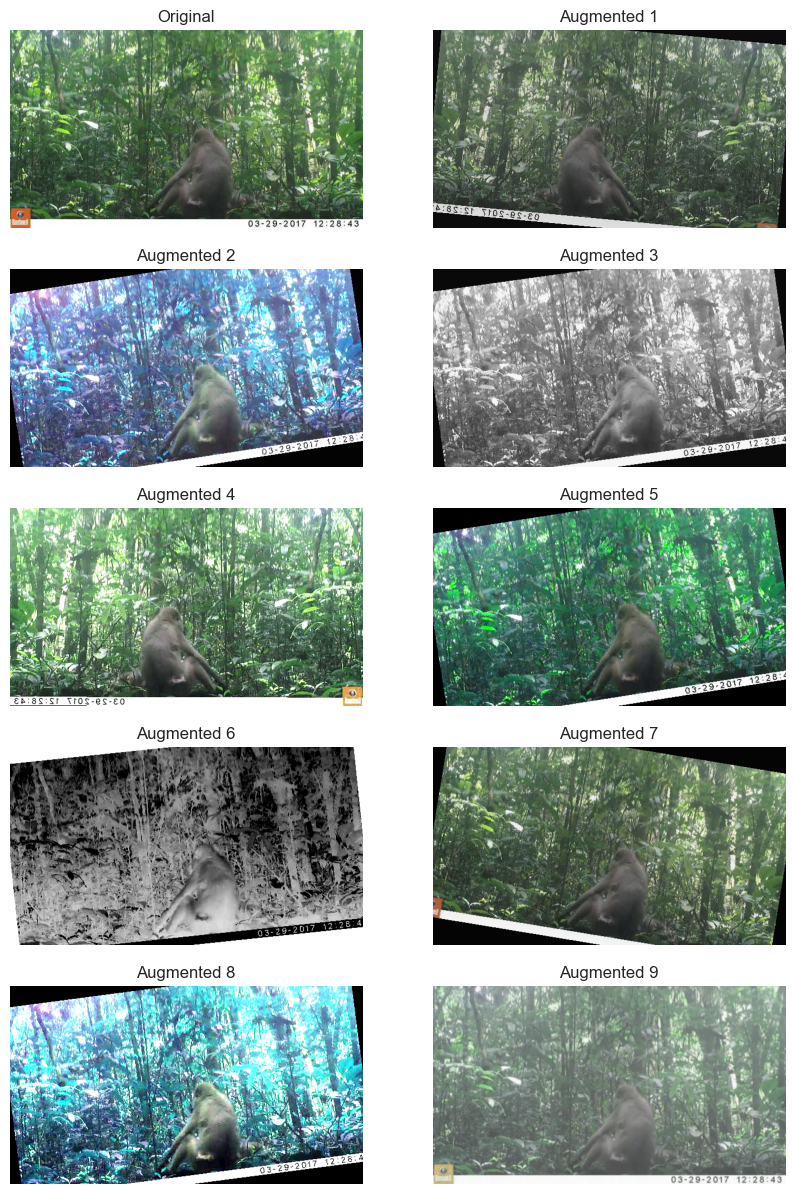

In [35]:
example = train_dataset[7211]
figure = plt.figure(figsize=(10, 15))

plt.subplot(5, 2, 1)
plt.axis("off")
plt.imshow(example["image"])
plt.title("Original")

for i in range(2, 11):
    plt.subplot(5, 2, i)
    plt.axis("off")
    plt.imshow(augmentation(example["image"]))
    plt.title(f"Augmented {i-1}")
plt.show()

In [6]:
transform = transforms.Compose(
            [
                augmentation,
                transforms.Resize((240, 240)),
                transforms.CenterCrop(224),
                transforms.ToTensor(),
                transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
            ])

In [7]:
train_dataset.transform = transform

In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

Device: cuda


In [9]:
class JungleWatch(torch.nn.Module):

    def __init__(self):
        super(JungleWatch, self).__init__()
        self.resnet = torchvision.models.resnet50(weights="IMAGENET1K_V2")

        for param in self.resnet.parameters():
            param.requires_grad = False

        self.resnet.fc = torch.nn.Linear(self.resnet.fc.in_features, 2)

        self.resnet.fc = torch.nn.Sequential(
            torch.nn.Linear(self.resnet.fc.in_features, 256),
            torch.nn.ReLU(inplace=True),
            torch.nn.Dropout(0.1),
            torch.nn.Linear(256, 8)
        )

    def forward(self, x):
        x = self.resnet(x)
        return x

In [10]:
net = JungleWatch()
net.load_state_dict(torch.load("models/JungleWatch40.pth"))
net.to(device)
summary(net, input_size=(1, 3, 224, 224))

Layer (type:depth-idx)                        Output Shape              Param #
JungleWatch                                   [1, 8]                    --
├─ResNet: 1-1                                 [1, 8]                    --
│    └─Conv2d: 2-1                            [1, 64, 112, 112]         (9,408)
│    └─BatchNorm2d: 2-2                       [1, 64, 112, 112]         (128)
│    └─ReLU: 2-3                              [1, 64, 112, 112]         --
│    └─MaxPool2d: 2-4                         [1, 64, 56, 56]           --
│    └─Sequential: 2-5                        [1, 256, 56, 56]          --
│    │    └─Bottleneck: 3-1                   [1, 256, 56, 56]          (75,008)
│    │    └─Bottleneck: 3-2                   [1, 256, 56, 56]          (70,400)
│    │    └─Bottleneck: 3-3                   [1, 256, 56, 56]          (70,400)
│    └─Sequential: 2-6                        [1, 512, 28, 28]          --
│    │    └─Bottleneck: 3-4                   [1, 512, 28, 28]       

In [10]:
train_size = int(0.80 * len(train_dataset))
test_size = len(train_dataset) - train_size
print("Train size:", train_size)
print("Test size:", test_size)

Train size: 13220
Test size: 3306


In [11]:
generator = torch.Generator()
generator.manual_seed(0)

"""
# CUSTOM SIZES
train_size = 5
test_size = 1
total = train_size + test_size

mini_dataset, rest_of_dataset = torch.utils.data.random_split(train_dataset, [total, len(train_dataset)-total], generator=generator)
training_dataset, test_dataset = torch.utils.data.random_split(mini_dataset, [train_size, test_size], generator=generator)
"""

training_dataset, test_dataset = random_split(train_dataset, [train_size, test_size], generator=generator)

train_loader = DataLoader(training_dataset, batch_size=32, shuffle=True, num_workers=0, pin_memory=True)
train_iter = iter(train_loader)
train_sample = next(train_iter)

print("Train Image Shape", train_sample["image"].shape)

test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False, num_workers=0, pin_memory=True)
test_iter = iter(test_loader)
test_sample = next(test_iter)

print("Test Image Shape", test_sample["image"].shape)

Train Image Shape torch.Size([32, 3, 224, 224])
Test Image Shape torch.Size([256, 3, 224, 224])


In [46]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 10, 0.5)

In [47]:
epochs = 40
batches_before_log = 100

epoch_log = []
train_loss_log = []
test_loss_log = []

for epoch in range(0, epochs):
    print(f'Starting Epoch: {epoch+1}...')

    total_batch_loss = 0.0
    total_test_loss = 0.0
    train_loss_list = []
    test_loss_list = []

    for batch_index, batch_data in enumerate(train_loader):

        images_train = batch_data["image"]
        labels_train = batch_data["label"]

        images_train = images_train.to(device, non_blocking=True)
        labels_train = labels_train.to(device, non_blocking=True)


        optimizer.zero_grad()

        labels_pred = net(images_train)

        batch_loss = criterion(labels_pred, labels_train)
        batch_loss.backward()
        optimizer.step()

        total_batch_loss += batch_loss.item()

        if batch_index % batches_before_log == batches_before_log - 1:

            total_test_batch_loss = 0.0

            net.eval()
            with torch.no_grad():
                test_batch_count = 0
                for test_batch_index, test_batch_data in enumerate(test_loader):
                    images_test = test_batch_data["image"]
                    labels_test = test_batch_data["label"]

                    images_test = images_test.to(device, non_blocking=True)
                    labels_test = labels_test.to(device, non_blocking=True)

                    labels_test_pred = net(images_test)

                    test_batch_loss = criterion(labels_test_pred, labels_test)
                    total_test_batch_loss += test_batch_loss.item()

                    test_batch_count += 1

                avg_test_batch_loss = total_test_batch_loss / test_batch_count

            net.train()
            train_loss = total_batch_loss/batches_before_log
            test_loss = avg_test_batch_loss
            train_loss_list.append(train_loss)
            test_loss_list.append(test_loss)
            print(f'Epoch: {epoch+1}, Mini-Batches Completed: {(batch_index+1)},'
                  f' Train Loss: {train_loss:.3f},'
                  f' Test Loss = {test_loss:.3f}')

            total_batch_loss = 0.0
            total_test_loss = 0.0

    epoch_log.append(epoch+1)
    train_loss_mean = np.mean(train_loss_list)
    train_loss_log.append(train_loss_mean)
    print("MEAN TRAIN LOSS OF EPOCH:", train_loss_mean)
    test_loss_mean = np.mean(test_loss_list)
    test_loss_log.append(test_loss_mean)
    print("MEAN TEST LOSS OF EPOCH:", test_loss_mean)

    scheduler.step()
    print('Learning rate: {0}'.format(optimizer.param_groups[0]['lr']))

    torch.save(net.state_dict(), f"models/JungleWatch{epoch+1}.pth")
    print("Net Saved")

print("Finished Training")

Starting Epoch: 1...
Epoch: 1, Mini-Batches Completed: 100, Train Loss: 1.679, Test Loss = 1.473
Epoch: 1, Mini-Batches Completed: 200, Train Loss: 1.497, Test Loss = 1.371
Epoch: 1, Mini-Batches Completed: 300, Train Loss: 1.432, Test Loss = 1.366
Epoch: 1, Mini-Batches Completed: 400, Train Loss: 1.385, Test Loss = 1.316
MEAN TRAIN LOSS OF EPOCH: 1.4984153029322624
MEAN TEST LOSS OF EPOCH: 1.3814575855548565
Learning rate: 0.001
Net Saved
Starting Epoch: 2...
Epoch: 2, Mini-Batches Completed: 100, Train Loss: 1.323, Test Loss = 1.255
Epoch: 2, Mini-Batches Completed: 200, Train Loss: 1.291, Test Loss = 1.278
Epoch: 2, Mini-Batches Completed: 300, Train Loss: 1.307, Test Loss = 1.215
Epoch: 2, Mini-Batches Completed: 400, Train Loss: 1.266, Test Loss = 1.222
MEAN TRAIN LOSS OF EPOCH: 1.2967629635334015
MEAN TEST LOSS OF EPOCH: 1.2423671713242164
Learning rate: 0.001
Net Saved
Starting Epoch: 3...
Epoch: 3, Mini-Batches Completed: 100, Train Loss: 1.244, Test Loss = 1.222
Epoch: 3, Min

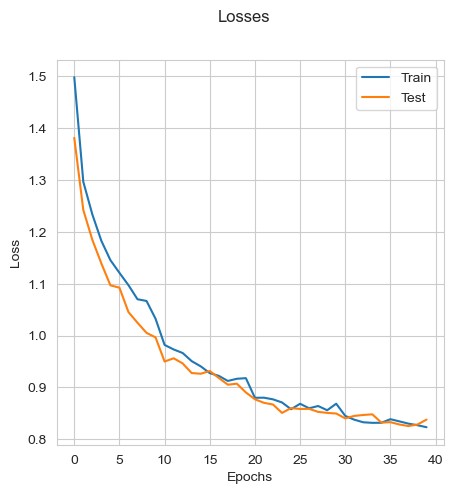

In [51]:
fig = plt.figure(figsize=(5, 5))
plt.plot(train_loss_log, label="Train")
plt.plot(test_loss_log, label="Test")
plt.suptitle("Losses")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [12]:
net = JungleWatch()
net.load_state_dict(torch.load("models/JungleWatch40.pth"))

for param in net.parameters():
    param.requires_grad = True

net.to(device)
summary(net)

Layer (type:depth-idx)                        Param #
JungleWatch                                   --
├─ResNet: 1-1                                 --
│    └─Conv2d: 2-1                            9,408
│    └─BatchNorm2d: 2-2                       128
│    └─ReLU: 2-3                              --
│    └─MaxPool2d: 2-4                         --
│    └─Sequential: 2-5                        --
│    │    └─Bottleneck: 3-1                   75,008
│    │    └─Bottleneck: 3-2                   70,400
│    │    └─Bottleneck: 3-3                   70,400
│    └─Sequential: 2-6                        --
│    │    └─Bottleneck: 3-4                   379,392
│    │    └─Bottleneck: 3-5                   280,064
│    │    └─Bottleneck: 3-6                   280,064
│    │    └─Bottleneck: 3-7                   280,064
│    └─Sequential: 2-7                        --
│    │    └─Bottleneck: 3-8                   1,512,448
│    │    └─Bottleneck: 3-9                   1,117,184
│    │    └─Bo

In [13]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.00005)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 2, 0.5)

In [14]:
epochs = 50
batches_before_log = 50

epoch_log = []
train_loss_log = []
test_loss_log = []

for epoch in range(40, epochs):
    print(f'Starting Epoch: {epoch+1}...')

    total_batch_loss = 0.0
    total_test_loss = 0.0
    train_loss_list = []
    test_loss_list = []

    for batch_index, batch_data in enumerate(train_loader):

        images_train = batch_data["image"]
        labels_train = batch_data["label"]

        images_train = images_train.to(device, non_blocking=True)
        labels_train = labels_train.to(device, non_blocking=True)


        optimizer.zero_grad()

        labels_pred = net(images_train)

        batch_loss = criterion(labels_pred, labels_train)
        batch_loss.backward()
        optimizer.step()

        total_batch_loss += batch_loss.item()

        if batch_index % batches_before_log == batches_before_log - 1:

            total_test_batch_loss = 0.0

            net.eval()
            with torch.no_grad():
                test_batch_count = 0
                for test_batch_index, test_batch_data in enumerate(test_loader):
                    images_test = test_batch_data["image"]
                    labels_test = test_batch_data["label"]

                    images_test = images_test.to(device, non_blocking=True)
                    labels_test = labels_test.to(device, non_blocking=True)

                    labels_test_pred = net(images_test)

                    test_batch_loss = criterion(labels_test_pred, labels_test)
                    total_test_batch_loss += test_batch_loss.item()

                    test_batch_count += 1

                avg_test_batch_loss = total_test_batch_loss / test_batch_count

            net.train()
            train_loss = total_batch_loss/batches_before_log
            test_loss = avg_test_batch_loss
            train_loss_list.append(train_loss)
            test_loss_list.append(test_loss)
            print(f'Epoch: {epoch+1}, Mini-Batches Completed: {(batch_index+1)},'
                  f' Train Loss: {train_loss:.3f},'
                  f' Test Loss = {test_loss:.3f}')

            total_batch_loss = 0.0
            total_test_loss = 0.0

    epoch_log.append(epoch+1)
    train_loss_mean = np.mean(train_loss_list)
    train_loss_log.append(train_loss_mean)
    print("MEAN TRAIN LOSS OF EPOCH:", train_loss_mean)
    test_loss_mean = np.mean(test_loss_list)
    test_loss_log.append(test_loss_mean)
    print("MEAN TEST LOSS OF EPOCH:", test_loss_mean)

    scheduler.step()
    print('Learning rate: {0}'.format(optimizer.param_groups[0]['lr']))

    torch.save(net.state_dict(), f"models/JungleWatch{epoch+1}.pth")
    print("Net Saved")

print("Finished Training")

Starting Epoch: 41...
Epoch: 41, Mini-Batches Completed: 50, Train Loss: 0.774, Test Loss = 0.823
Epoch: 41, Mini-Batches Completed: 100, Train Loss: 0.823, Test Loss = 0.830
Epoch: 41, Mini-Batches Completed: 150, Train Loss: 0.794, Test Loss = 0.799
Epoch: 41, Mini-Batches Completed: 200, Train Loss: 0.793, Test Loss = 0.785
Epoch: 41, Mini-Batches Completed: 250, Train Loss: 0.774, Test Loss = 0.764
Epoch: 41, Mini-Batches Completed: 300, Train Loss: 0.764, Test Loss = 0.759
Epoch: 41, Mini-Batches Completed: 350, Train Loss: 0.751, Test Loss = 0.727
Epoch: 41, Mini-Batches Completed: 400, Train Loss: 0.777, Test Loss = 0.751
MEAN TRAIN LOSS OF EPOCH: 0.7811695001274348
MEAN TEST LOSS OF EPOCH: 0.7797756739533865
Learning rate: 5e-05
Net Saved
Starting Epoch: 42...
Epoch: 42, Mini-Batches Completed: 50, Train Loss: 0.690, Test Loss = 0.732
Epoch: 42, Mini-Batches Completed: 100, Train Loss: 0.719, Test Loss = 0.725
Epoch: 42, Mini-Batches Completed: 150, Train Loss: 0.693, Test Loss

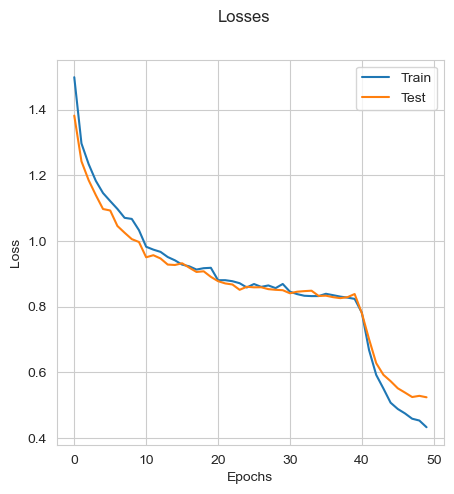

In [26]:
fig = plt.figure(figsize=(5, 5))
plt.plot(train_loss, label="Train")
plt.plot(test_loss, label="Test")
plt.suptitle("Losses")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [15]:
preds_collector = []
gt_collector = []

net.eval()
with torch.no_grad():
    for test_batch_index, test_batch_data in enumerate(test_loader):
        print("Batch:", test_batch_index)

        test_image = test_batch_data["image"].to(device)
        test_label = test_batch_data["label"]
        logits = net(test_image)
        preds = torch.nn.functional.softmax(logits, dim=1)
        preds = preds.to("cpu")

        preds_df = pd.DataFrame(
            preds.detach().numpy(),
            index=test_batch_data["image_id"],
            columns=["antelope_duiker", "bird", "blank", "civet_genet", "hog", "leopard", "monkey_prosimian", "rodent"],
        )
        gt_df = pd.DataFrame(
            test_label.detach().numpy(),
            index=test_batch_data["image_id"],
            columns=["antelope_duiker", "bird", "blank", "civet_genet", "hog", "leopard", "monkey_prosimian", "rodent"],
        )
        preds_collector.append(preds_df)
        gt_collector.append(gt_df)
print("Test prediction done!")
test_preds_df = pd.concat(preds_collector)
test_gt_df = pd.concat(gt_collector)

Batch: 0
Batch: 1
Batch: 2
Batch: 3
Batch: 4
Batch: 5
Batch: 6
Batch: 7
Batch: 8
Batch: 9
Batch: 10
Batch: 11
Batch: 12
Test prediction done!


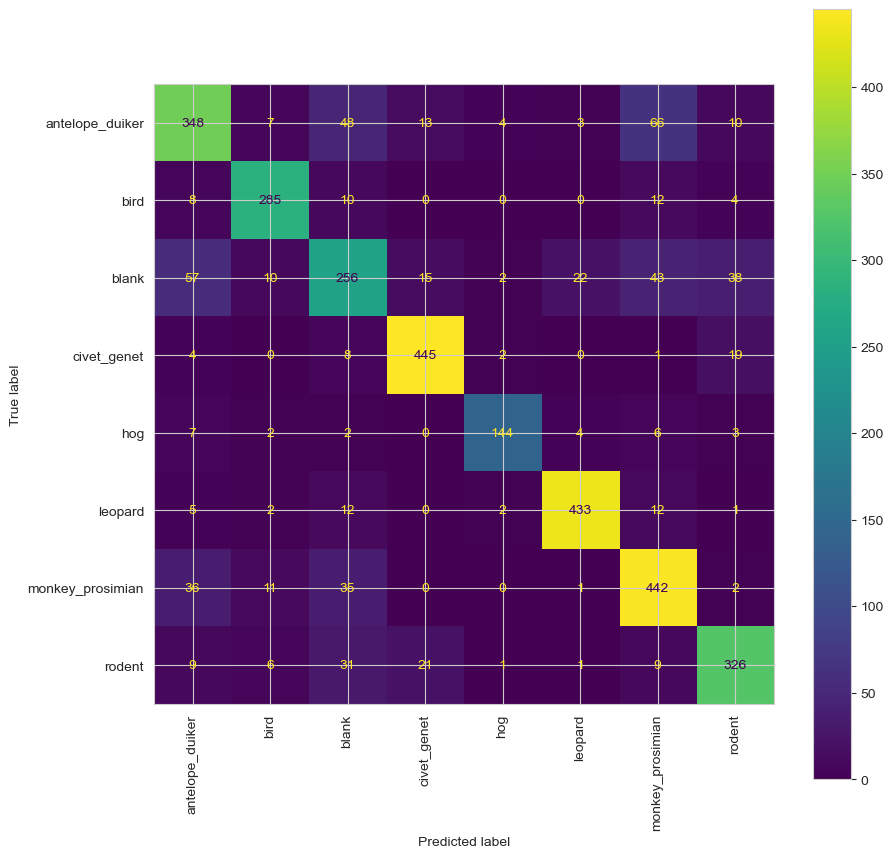

In [16]:
fig, ax = plt.subplots(figsize=(10, 10))
cm = ConfusionMatrixDisplay.from_predictions(
    test_gt_df.idxmax(axis=1),
    test_preds_df.idxmax(axis=1),
    ax=ax,
    xticks_rotation=90,
    colorbar=True,
)